# Main

In [1]:
import torch
import os, cv2
import pandas as pd
import random, tqdm
from torch import nn, einsum
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import albumentations as album


## Model Class

In [2]:
#%run modelV5.ipynb

## Data Class

In [3]:
%run datasets.ipynb

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]
Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


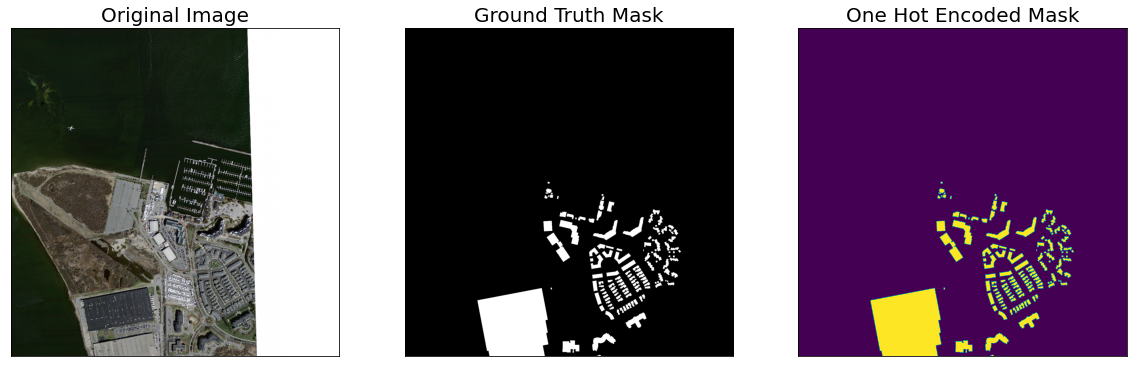

image: (1500, 1500, 3)
mask: (1500, 1500, 2)
reverse mask: (1500, 1500)
colour_code mask: (1500, 1500, 3)


In [4]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize( original_image = image,
           ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
           one_hot_encoded_mask = reverse_one_hot(mask) )
print('image:',image.shape)
print('mask:',mask.shape)
print('reverse mask:',reverse_one_hot(mask).shape)
print('colour_code mask:',colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values).shape)



### Augmentation and preprocessing

In [5]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [        
        album.CenterCrop (height=512, width=512, always_apply=True)        
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

## Trainnig

In [6]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)


valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [7]:
#torch.cuda.empty_cache()
%run modelV6.ipynb

In [8]:
from torchinfo import summary
model = CvT()
# model = CvT(
#     num_classes=2, s1_emb_dim=64, s1_emb_kernel=5, s1_emb_stride=2,
#     s1_proj_kernel=3, s1_kv_proj_stride=2, s1_heads=1, s1_depth=1, s1_mlp_mult=4,
    
#     s2_emb_dim=64, s2_emb_kernel=3, s2_emb_stride=2, s2_proj_kernel=3, s2_kv_proj_stride=2,
#     s2_heads=3, s2_depth=2, s2_mlp_mult=4,
    
#     s3_emb_dim=64, s3_emb_kernel=3, s3_emb_stride=2, s3_proj_kernel=3,
#     s3_kv_proj_stride=2, s3_heads=4, s3_depth=10, s3_mlp_mult=4, dropout=0.,
#     up_sample_mode='bilinear')

#model = nn.DataParallel(model);
#summary( model.to('cpu'), (1, 3, 256, 256), col_width=16, verbose=1)

In [9]:
TRAINING = True
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#weights = torch.tensor([0.1, 4.7])
#loss = WCrossEntropy()
#%loss = IoULoss()
loss = DiceBCELoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    #smp.utils.metrics.Accuracy(threshold=0.5),
]
optimizer = torch.optim.Adamax([dict(params=model.parameters(), lr=0.00008),])  #lr=0.00008
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=1,T_mult=2,eta_min=5e-5,)

In [10]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)


In [11]:
torch.cuda.empty_cache()
# load best saved model checkpoint from previous commit (if present)
if os.path.exists('./best_model.pth'):
    model = torch.load('./best_model.pth', map_location=DEVICE)
    print("Model load!")

Model load!


In [12]:
%%time
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|████████████████████| 4/4 [00:02<00:00,  1.91it/s, DiceBCELoss - 1.133, iou_score - 0.2708, fscore - 0.393]
Model saved!

Epoch: 1
valid: 100%|██████████████████| 4/4 [00:01<00:00,  2.84it/s, DiceBCELoss - 0.9472, iou_score - 0.4839, fscore - 0.6338]
Model saved!

Epoch: 2
valid: 100%|███████████████████| 4/4 [00:01<00:00,  2.82it/s, DiceBCELoss - 0.9069, iou_score - 0.555, fscore - 0.7055]
Model saved!

Epoch: 3
valid: 100%|██████████████████| 4/4 [00:01<00:00,  2.81it/s, DiceBCELoss - 0.8722, iou_score - 0.5851, fscore - 0.7307]
Model saved!

Epoch: 4
valid: 100%|███████████████████| 4/4 [00:01<00:00,  2.88it/s, DiceBCELoss - 0.799, iou_score - 0.6538, fscore - 0.7872]
Model saved!

Epoch: 5
valid: 100%|███████████████████| 4/4 [00:01<00:00,  2.90it/s, DiceBCELoss - 0.8032, iou_score - 0.6422, fscore - 0.774]

Epoch: 6
valid: 100%|██████████████████| 4/4 [00:01<00:00,  2.86it/s, DiceBCELoss - 0.7704, iou_score - 0.6682, fscore - 0.7968]
Model saved!

Epoch: 7
va

In [ ]:
torch.save(model, './best_model.pth')

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df
#train_logs_df.to_excel('CrossEntropyWrongWeigth.xlsx')  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
train_logs_df.plot(ax=ax1, kind = 'line', title='Trainnig logs')
valid_logs_df.plot(ax=ax2, kind = 'line', title='Validation logs')
plt.show()

# Validation

In [ ]:
os.getcwd()

In [ ]:
DEVICE = 'cuda'
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded model from this run.')

# # load best saved model checkpoint from previous commit (if present)
# elif os.path.exists('../input/unet-for-building-segmentation-pytorch/best_model.pth'):
#     best_model = torch.load('../input/unet-for-building-segmentation-pytorch/best_model.pth', map_location=DEVICE)
#     print('Loaded UNet model from a previous commit.')

In [ ]:
def get_validation_augmentation_cpu():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [        
        album.CenterCrop (height=256, width=256, always_apply=True)        
    ]
    return album.Compose(test_transform)

#create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation_cpu(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation_cpu(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [ ]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[512,512,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(test_dataset)):

    random_idx = random.randint(0, len(test_dataset)-1)
    image, gt_mask = test_dataset[random_idx]
    image_vis = crop_image(test_dataset_vis[random_idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('building')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

In [ ]:
image, gt_mask = test_dataset[random_idx]
image_vis = crop_image(test_dataset_vis[random_idx][0].astype('uint8'))
x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
best_model(x_tensor)

In [ ]:
device_type = _get_available_device_type()